# Compare models trained on mixed class data

This compares several different models trained on **mixed** *longliner*,
*trawler* and *purse seiner* data.

**NOTE: this was somewhat unstable. Running multiple times yielded significantly different results, 
  depending the data split.  I set seeds everywhere and now the output is stable. However, this tells 
  me that we want more data!**

In [1]:
%matplotlib inline
import numpy as np
from vessel_scoring import data
from vessel_scoring.evaluate_model import evaluate_model, train_model, compare_models
from IPython.core.display import display, HTML

In [2]:
x_tran, xtrain_tran, xcross_tran, xtest_tran = data.load_dataset_by_vessel('datasets/slow-transits.measures.npz',
                                                                     even_split=False)

Warning, insufficient items to sample, returning all
Warning, inufficient items to sample, returning 3168


In [3]:
set(x_tran['mmsi'])

{367512180.0, 367512510.0, 367534310.0, 367721000.0}

In [3]:
_, xtrain_trawl, xcross_trawl, xtest_trawl = data.load_dataset_by_vessel('datasets/kristina_trawl.measures.npz')
_, xtrain_lline, xcross_lline, xtest_lline = data.load_dataset_by_vessel('datasets/kristina_longliner.measures.npz')
_, xtrain_pseine, xcross_pseine, xtest_pseine = data.load_dataset_by_vessel('datasets/kristina_ps.measures.npz')

In [4]:
def clone_subset(x, dtype):
    """copy only the portions of x in dtype to a new array"""
    new = np.zeros(x.shape, dtype=dtype)
    for name in dtype.names:
        new[name] = x[name]
    return new
        
# We need to make the fields in the tran data match that of the other 
# to concatenate
xtrain_tran = clone_subset(xtrain_tran, xtrain_lline.dtype)
xcross_tran = clone_subset(xcross_tran, xtrain_lline.dtype)
xtest_tran = clone_subset(xtest_tran, xtrain_lline.dtype)

In [5]:
TRANSIT_WEIGHT = 10

xtrain = np.concatenate([xtrain_trawl, xtrain_lline, xtrain_pseine] + [xtrain_tran] * TRANSIT_WEIGHT)
xcross = np.concatenate([xcross_trawl, xcross_lline, xcross_pseine] + [xcross_tran] * TRANSIT_WEIGHT)

train = np.concatenate([xtrain, xcross])

xtest = np.concatenate([xtest_trawl, xtest_lline, xtest_pseine, xtest_tran])

In [7]:
from vessel_scoring.legacy_heuristic_model import LegacyHeuristicModel
from vessel_scoring.random_forest_model import RandomForestModel
from vessel_scoring.logistic_model import LogisticModel
import imp, vessel_scoring.nnet_model; imp.reload(vessel_scoring.nnet_model)
#from vessel_scoring.nnet_model_proto import NNetModelProto
from vessel_scoring.nnet_model import NNetModel

untrained_models = dict([
    ('Logistic', LogisticModel(colspec=dict(windows=[43200]), order=6)),
    ('Logistic opt MSE', LogisticModel(colspec=dict(windows=[43200]), order=4, cross=3)),
#     ('Logistic (MW)', LogisticModel(windows=[1800, 3600, 10800, 21600, 43200, 86400], order=6)),
#     ('Logistic (MW/cross3)', LogisticModel(windows=[1800, 3600, 10800, 21600, 43200, 86400], order=6, cross=2)),
#     ('Random Forest', RandomForestModel(windows=[43200])),
    ('NN', NNetModel()),
#    ('NN Proto', NNetModelProto()),
    ('Random Forest (MW)', RandomForestModel(windows=[1800, 3600, 10800, 21600, 43200, 86400])),
#     ('Legacy', LegacyHeuristicModel(window=3600)),
#     ("Legacy (3 Hour)", LegacyHeuristicModel(window=10800)),
#     ("Legacy (12 Hour)", LegacyHeuristicModel(window=43200)),
#     ("Legacy (24 Hour)", LegacyHeuristicModel(window=86400)),  
])

trained_models = dict((name, train_model(mdl, train)) for (name, mdl) in untrained_models.iteritems())

Step 0: loss = 0.75 (0.049 sec)
Step 100: loss = 0.31 (0.008 sec)
Step 200: loss = 0.28 (0.004 sec)
Step 300: loss = 0.19 (0.006 sec)
Step 400: loss = 0.20 (0.005 sec)
Step 500: loss = 0.19 (0.005 sec)
Step 600: loss = 0.22 (0.005 sec)
Step 700: loss = 0.24 (0.004 sec)
Epoch: 1
Training Data Eval:
  Num examples: 94208  Num correct: 87039  Precision @ 1: 0.9239
Validation Data Eval:
  Num examples: 4864  Num correct: 4512  Precision @ 1: 0.9276
Step 800: loss = 0.09 (0.005 sec)
Step 900: loss = 0.20 (0.006 sec)
Step 1000: loss = 0.16 (0.010 sec)
Step 1100: loss = 0.15 (0.005 sec)
Step 1200: loss = 0.28 (0.009 sec)
Step 1300: loss = 0.30 (0.010 sec)
Step 1400: loss = 0.16 (0.014 sec)
Epoch: 2
Training Data Eval:
  Num examples: 94208  Num correct: 87450  Precision @ 1: 0.9283
Validation Data Eval:
  Num examples: 4864  Num correct: 4533  Precision @ 1: 0.9319
Step 1500: loss = 0.18 (0.005 sec)
Step 1600: loss = 0.14 (0.007 sec)
Step 1700: loss = 0.20 (0.005 sec)
Step 1800: loss = 0.26 (

In [13]:
import imp, vessel_scoring.nnet_model; imp.reload(vessel_scoring.nnet_model)

untrained_models['NN'] = NNetModel()
trained_models['NN'] = train_model(untrained_models['NN'], train)

Step 0: loss = 0.78 (0.064 sec)
Step 100: loss = 0.36 (0.005 sec)
Step 200: loss = 0.23 (0.016 sec)
Step 300: loss = 0.23 (0.005 sec)
Step 400: loss = 0.22 (0.006 sec)
Step 500: loss = 0.22 (0.005 sec)
Step 600: loss = 0.28 (0.005 sec)
Step 700: loss = 0.17 (0.005 sec)
Epoch: 1
Training Data Eval:
  Num examples: 94208  Num correct: 86675  Precision @ 1: 0.9200
Validation Data Eval:
  Num examples: 4864  Num correct: 4441  Precision @ 1: 0.9130
Step 800: loss = 0.16 (0.006 sec)
Step 900: loss = 0.19 (0.004 sec)
Step 1000: loss = 0.24 (0.005 sec)
Step 1100: loss = 0.22 (0.005 sec)
Step 1200: loss = 0.26 (0.003 sec)
Step 1300: loss = 0.24 (0.006 sec)
Step 1400: loss = 0.17 (0.006 sec)
Epoch: 2
Training Data Eval:
  Num examples: 94208  Num correct: 87190  Precision @ 1: 0.9255
Validation Data Eval:
  Num examples: 4864  Num correct: 4495  Precision @ 1: 0.9241
Step 1500: loss = 0.13 (0.007 sec)
Step 1600: loss = 0.21 (0.008 sec)
Step 1700: loss = 0.16 (0.004 sec)
Step 1800: loss = 0.17 (

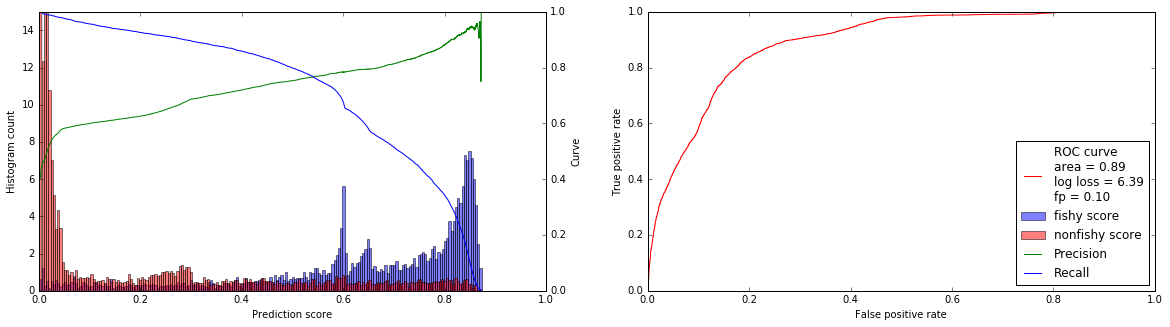

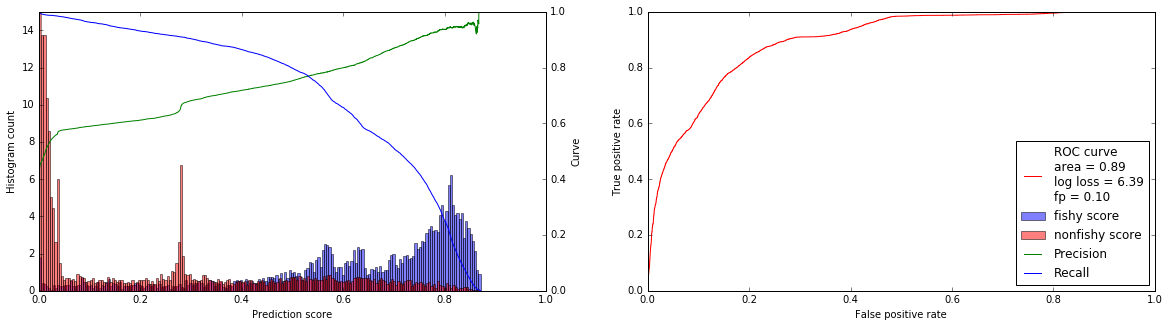

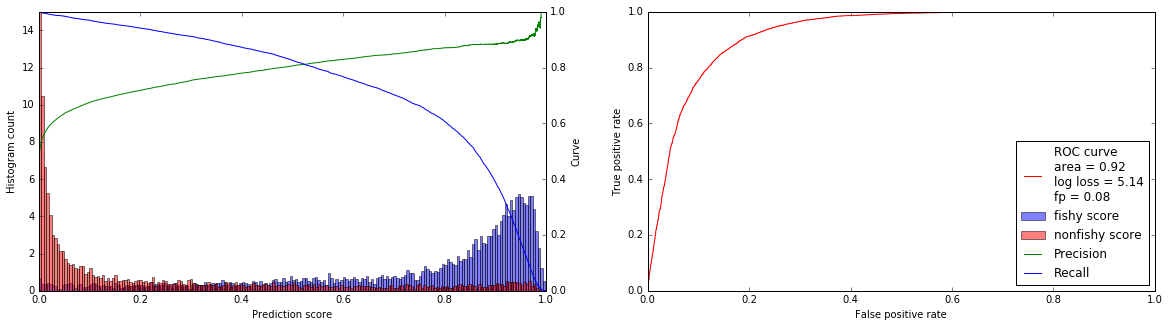

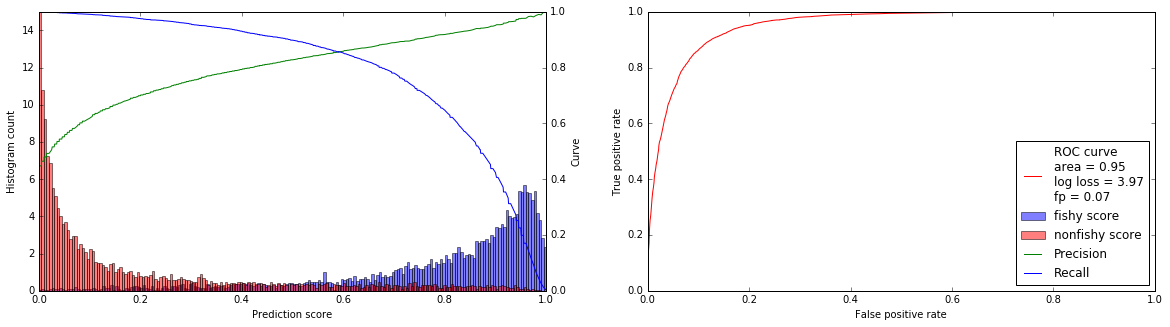

In [8]:

display(HTML("<h1>Overall Comparison</h1>"))
for name, mdl in trained_models.iteritems():
    evaluate_model(mdl, xtest, name=name)


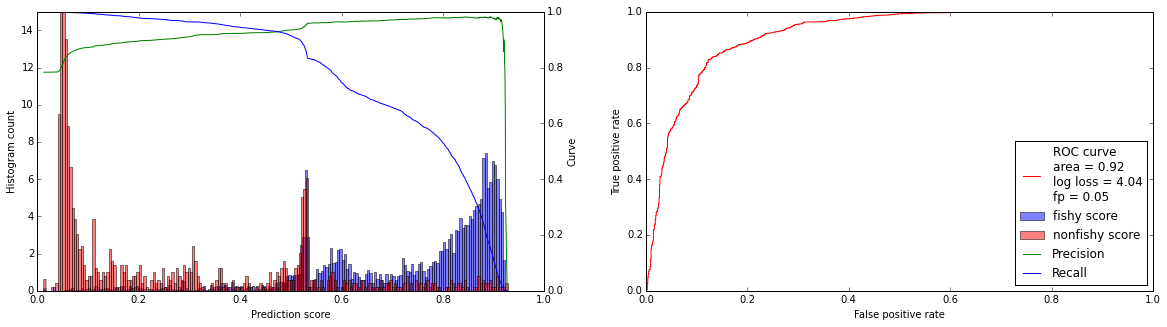

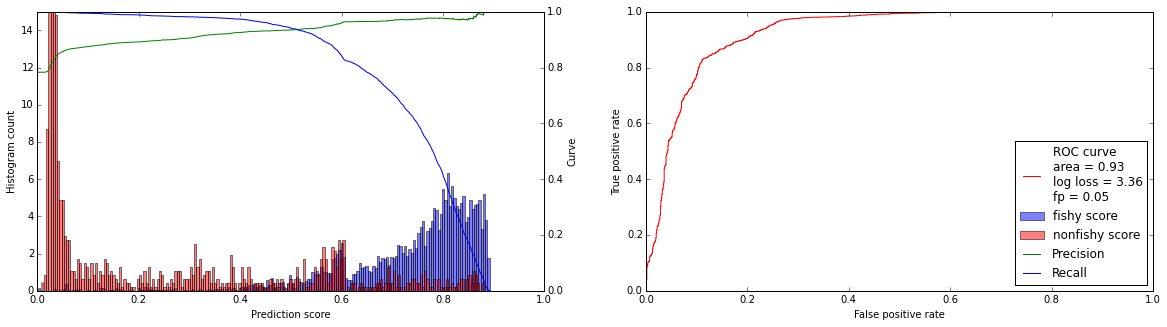

Step 0: loss = 0.78 (0.015 sec)
Epoch: 1
Training Data Eval:
  Num examples: 9472  Num correct: 7819  Precision @ 1: 0.8255
Validation Data Eval:
  Num examples: 384  Num correct: 305  Precision @ 1: 0.7943
Step 100: loss = 0.42 (0.002 sec)
Epoch: 2
Training Data Eval:
  Num examples: 9472  Num correct: 7909  Precision @ 1: 0.8350
Validation Data Eval:
  Num examples: 384  Num correct: 307  Precision @ 1: 0.7995
Step 200: loss = 0.34 (0.002 sec)
Epoch: 3
Training Data Eval:
  Num examples: 9472  Num correct: 7923  Precision @ 1: 0.8365
Validation Data Eval:
  Num examples: 384  Num correct: 314  Precision @ 1: 0.8177
Epoch: 4
Training Data Eval:
  Num examples: 9472  Num correct: 7985  Precision @ 1: 0.8430
Validation Data Eval:
  Num examples: 384  Num correct: 314  Precision @ 1: 0.8177
Step 300: loss = 0.45 (0.003 sec)
Epoch: 5
Training Data Eval:
  Num examples: 9472  Num correct: 8064  Precision @ 1: 0.8514
Validation Data Eval:
  Num examples: 384  Num correct: 313  Precision @ 1

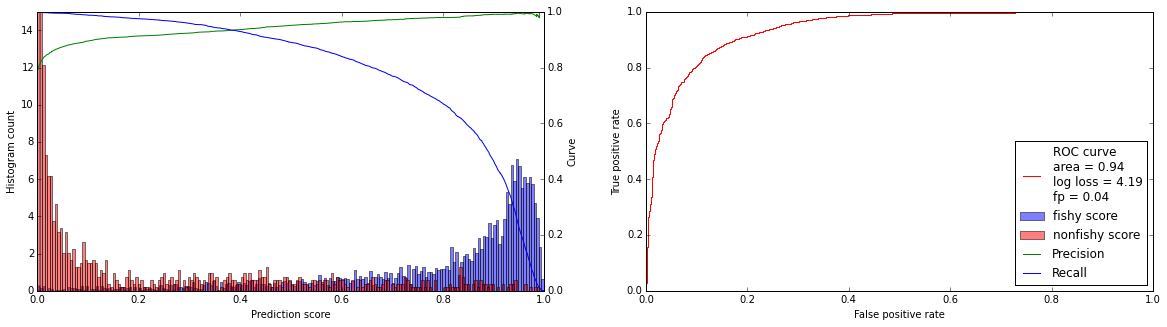

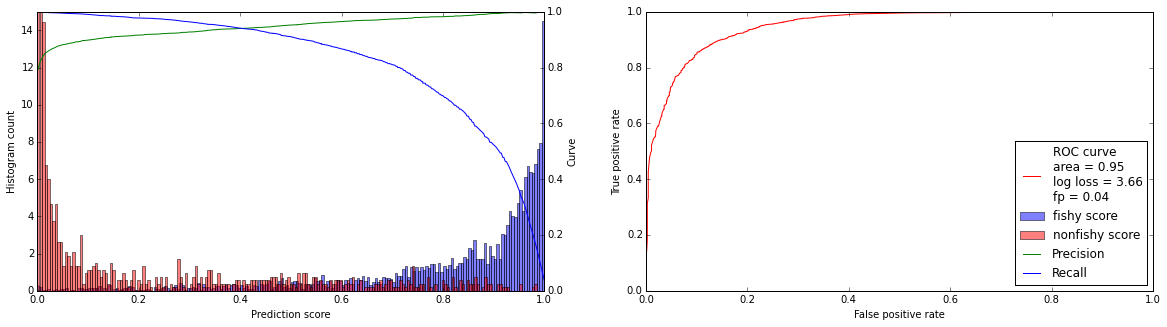

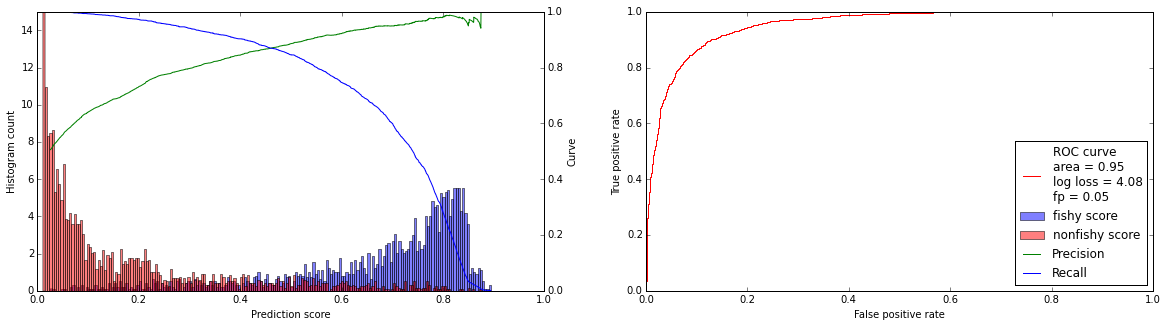

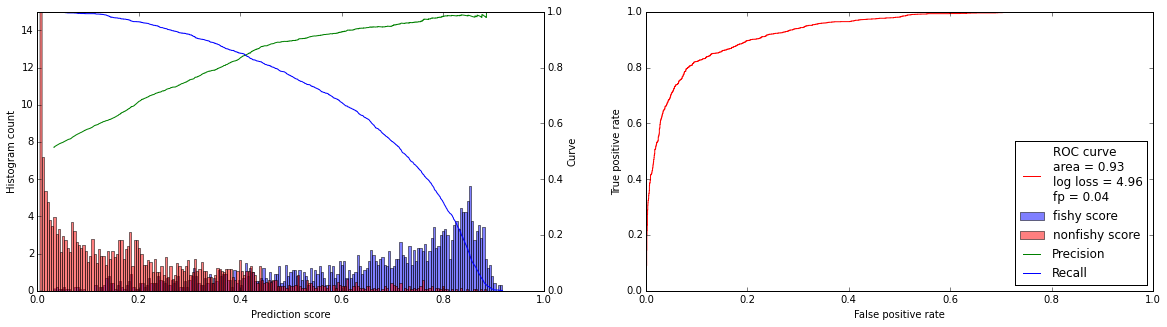

Step 0: loss = 0.74 (0.015 sec)
Epoch: 1
Training Data Eval:
  Num examples: 9472  Num correct: 7845  Precision @ 1: 0.8282
Validation Data Eval:
  Num examples: 384  Num correct: 312  Precision @ 1: 0.8125
Step 100: loss = 0.41 (0.002 sec)
Epoch: 2
Training Data Eval:
  Num examples: 9472  Num correct: 7896  Precision @ 1: 0.8336
Validation Data Eval:
  Num examples: 384  Num correct: 325  Precision @ 1: 0.8464
Step 200: loss = 0.46 (0.002 sec)
Epoch: 3
Training Data Eval:
  Num examples: 9472  Num correct: 7950  Precision @ 1: 0.8393
Validation Data Eval:
  Num examples: 384  Num correct: 322  Precision @ 1: 0.8385
Epoch: 4
Training Data Eval:
  Num examples: 9472  Num correct: 7992  Precision @ 1: 0.8438
Validation Data Eval:
  Num examples: 384  Num correct: 324  Precision @ 1: 0.8438
Step 300: loss = 0.43 (0.004 sec)
Epoch: 5
Training Data Eval:
  Num examples: 9472  Num correct: 8006  Precision @ 1: 0.8452
Validation Data Eval:
  Num examples: 384  Num correct: 321  Precision @ 1

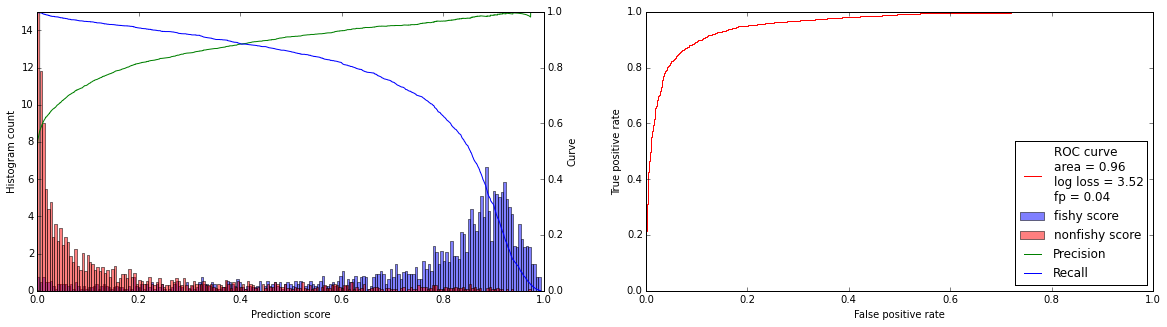

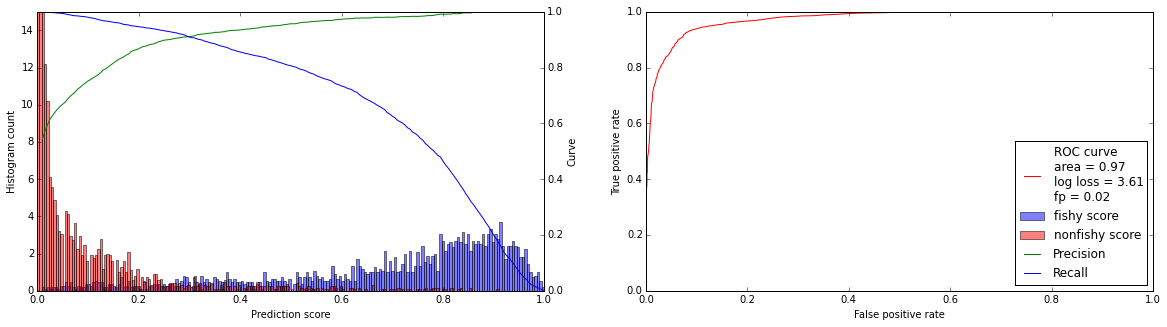

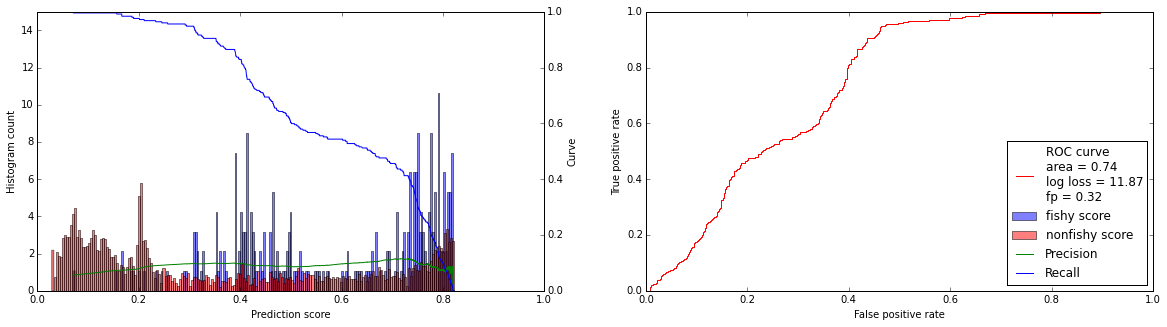

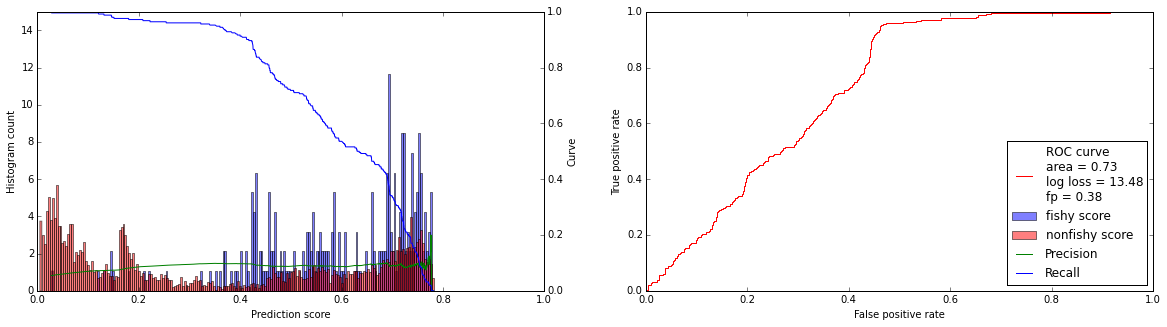

Step 0: loss = 0.74 (0.016 sec)
Epoch: 1
Training Data Eval:
  Num examples: 9472  Num correct: 8189  Precision @ 1: 0.8645
Validation Data Eval:
  Num examples: 384  Num correct: 308  Precision @ 1: 0.8021
Step 100: loss = 0.26 (0.002 sec)
Epoch: 2
Training Data Eval:
  Num examples: 9472  Num correct: 8204  Precision @ 1: 0.8661
Validation Data Eval:
  Num examples: 384  Num correct: 317  Precision @ 1: 0.8255
Step 200: loss = 0.29 (0.002 sec)
Epoch: 3
Training Data Eval:
  Num examples: 9472  Num correct: 8305  Precision @ 1: 0.8768
Validation Data Eval:
  Num examples: 384  Num correct: 319  Precision @ 1: 0.8307
Epoch: 4
Training Data Eval:
  Num examples: 9472  Num correct: 8361  Precision @ 1: 0.8827
Validation Data Eval:
  Num examples: 384  Num correct: 320  Precision @ 1: 0.8333
Step 300: loss = 0.37 (0.003 sec)
Epoch: 5
Training Data Eval:
  Num examples: 9472  Num correct: 8335  Precision @ 1: 0.8800
Validation Data Eval:
  Num examples: 384  Num correct: 322  Precision @ 1

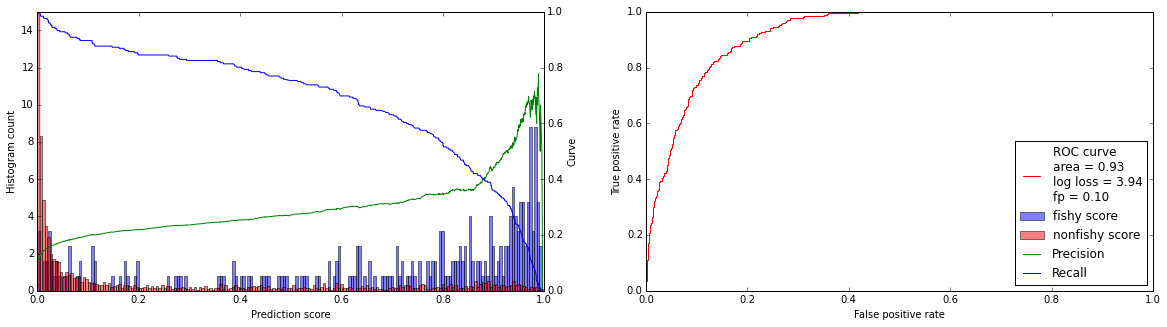

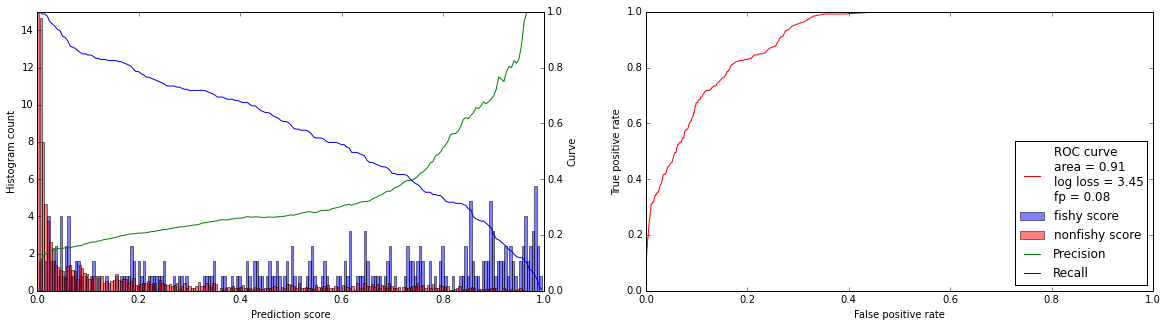

In [72]:

import imp, vessel_scoring.nnet_model; imp.reload(vessel_scoring.nnet_model)

for vessel_class, xtrain_class, xtest_class in  [("longliner", xtrain_lline, xtest_lline), 
                                                   ("trawler", xtrain_trawl, xtest_trawl), 
                                                   ("purse seine", xtrain_pseine, xtest_pseine)]:
    untrained_models = [
        ('Logistic', LogisticModel(colspec=dict(windows=[43200]), order=6)),
        ('Logistic opt MSE', LogisticModel(colspec=dict(windows=[43200]), order=4, cross=3)),
    #     ('Logistic (MW)', LogisticModel(windows=[1800, 3600, 10800, 21600, 43200, 86400], order=6)),
    #     ('Logistic (MW/cross3)', LogisticModel(windows=[1800, 3600, 10800, 21600, 43200, 86400], order=6, cross=2)),
    #     ('Random Forest', RandomForestModel(windows=[43200])),
        ('NN', NNetModel()),
#         ('NN Proto', NNetModelProto()),
        ('Random Forest (MW)', RandomForestModel(windows=[1800, 3600, 10800, 21600, 43200, 86400])),
    #     ('Legacy', LegacyHeuristicModel(window=3600)),
    #     ("Legacy (3 Hour)", LegacyHeuristicModel(window=10800)),
    #     ("Legacy (12 Hour)", LegacyHeuristicModel(window=43200)),
    #     ("Legacy (24 Hour)", LegacyHeuristicModel(window=86400)),  
    ]
    display(HTML("<h1>Comparison for {0}</h1>".format(vessel_class)))
    for name, mdl in untrained_models:
        mdl = train_model(mdl, xtrain_class)
        evaluate_model(mdl, xtest_class, name=name)
#     display(HTML("<h1>Comparison for {0}</h1>".format(vessel_class)))
#     compare_models(trained_models, xtest_class)

# How does this model do on the slow transit tracks?

In [ ]:
for name, mdl in trained_models:
    p = mdl.predict_proba(xtest_tran)[:,1]
    print name, p.mean(), (p > 0.5).mean()

## What about the new transit tracks?

In [ ]:
from vessel_scoring import data
x_tran2 = np.load('datasets/new_transits.measures.npz')['x']

# We are somehow getting an extra, 0 MMSI. Why?
# Results are totally bogus
x_tran2 = x_tran2[x_tran2['mmsi'] != 0]

print "Transit tracks for", sorted(set(x_tran2['mmsi']))
assert not (set(x_tran2['mmsi']) & set(x_tran['mmsi'])), "overlap between old and new transit sets"
print
for name, mdl in trained_models:
    p = mdl.predict_proba(x_tran2)[:,1]
    print name, p.mean(), (p > 0.5).mean()

## Where are the false positives?

The important thing is that the false positives are not evenly spaced out, so they shouldn't
show up as track like.

In [ ]:
import matplotlib.pyplot as plt
mmsi = sorted(set(x_tran2['mmsi']))

name, mdl = trained_models[1]

for m in mmsi:
    subset = x_tran2[x_tran2['mmsi'] == m]
    n = len(subset)
    locs = np.arange(n)[mdl.predict_proba(subset)[:,1] > 0.5]
    print "FP rate for MMSI", int(m), "is:", len(locs) / float(n)
    plt.figure()
    plt.title("MMSI {0}".format(m))
    plt.hist(locs, bins=100)

## Verify that we get same results when training using saved models

When loading from saved models we still get the same result

In [ ]:
from vessel_scoring.logistic_model import LogisticScorer
from glob import glob
import json
paths = glob("vessel_scoring/models/*.json")

print "Transit tracks for", sorted(set(x_tran2['mmsi']))
assert not (set(x_tran2['mmsi']) & set(x_tran['mmsi'])), "overlap between old and new transit sets"
print
for pth in paths:
    with open(pth) as f:
        args = json.load(f)['args']['args']
    mdl = LogisticScorer(**args)
    p = mdl.predict_proba(x_tran2)[:,1]
    print pth, p.mean(), (p > 0.5).mean()

## Results when not training with transit data.

    Logistic 0.838618506196 0.984949092519
    Logistic opt MSE 0.826260344662 0.986277113767
    Random Forest 0.718120849934 0.885790172643
    Legacy 0.623862134036 0.773351040283
    Legacy (12 Hour) 0.66843170167 0.912793271359
    
**If we don't train on these slow transit tracks, results are pretty awful**

# Dumping the model and using LogisticScorer

LogisticScorer is a simple reimplementation of the prediciton part of 
the logistic predictor. This way we can dump out the parameters from 
the model and then use it in the pipeline where we potentially can
optimize it for that particular application.

In [ ]:
from vessel_scoring.logistic_model import LogisticScorer

scorer = LogisticScorer(**trained_models[1][1].dump_dict())

print scorer.fishing_score(xtest).max()
print scorer.predict_proba(xtest)[:,1].max()
print trained_models[1][1].predict_proba(xtest)[:,1].max()

evaluate_model(scorer, xtest)

In [ ]:
# Verify that we can also load LogisticModels from dumped LogisticModels
# Had to abuse sklearn interface a bit for this to work
import imp, vessel_scoring.logistic_model
imp.reload(vessel_scoring.logistic_model)


from vessel_scoring.logistic_model import LogisticModel


model = LogisticModel(**trained_models[1][1].dump_dict())

print model.predict_proba(xtest)[:,1].max()
print trained_models[1][1].predict_proba(xtest)[:,1].max()

evaluate_model(model, xtest)

In [ ]:
import json

trained_models[1][1].dump_dict()

# Load existing models and evaluate

In [ ]:
import vessel_scoring.models
loaded_models = vessel_scoring.models.load_models()
dataset = vessel_scoring.models.load_data()

display(HTML("<h1>Overall Comparison</h1>"))
for name, mdl in loaded_models.iteritems():
    if '--' not in name:
        continue
        
    spec = vessel_scoring.models.untrained_models[name]

    test_data = [dataset[dataname]['test'] for dataname in spec['data']]
    test_data = vessel_scoring.utils.concatenate_different_recarrays(test_data)   

    method, dataname = name.split("--")
        
    evaluate_model(mdl, test_data, name="%s trained and tested on %s" % (method, dataname))

    generic_model = loaded_models[name.split("--")[0]]

    evaluate_model(generic_model, test_data, name="Generic %s tested on %s" % (method, dataname))
